First, load the data,in this notebook we are using the second Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". The data has been preprocessed in R (refer to the r script in iCloud/UTK/GRA-UTK/SelectMicro/MLonMicrobiome).

2) 836 samples: Flores GE, Caporaso JG, Henley JB, et al. Temporal variability is a personalized feature of the human microbiome. Genome Biol 2014

This data only has 220 genus because this is a subset of the original data used in the paper, the 220 features are the core features shared by all the 3 datasets in the paper.

The result is from sbatch script:

|                  | number      | Random Forest   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 220  | |0.736 (0.040)  |0.731 (0.046)|0.533 (0.080) |0.867 (0.032) |
| SelectMicro| 45  | |0.736 (0.043) |0.731 (0.047) | 0.540 (0.079) |0.880 (0.018) |
| Lasso_finetune    |15  | | 0.670 (0.030)|0.670 (0.032) |0.420 (0.065) |0.809 (0.033) |
| FS_Lasso_finetune |   14 |  | 0.661 (0.022) |0.660 (0.024) |0.408 (0.056) |0.808 (0.027) |


|                  | number      | XGboost   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 220  | |0.736 (0.042)  |0.735 (0.044)|0.540 (0.081)|0.869 (0.023) |
| SelectMicro| 45  | |0.732 (0.041) |0.729 (0.044) |0.536 (0.069) |0.865 (0.023) |
| Lasso_finetune    |15  | | 0.639 (0.027)|0.638 (0.027) |0.364 (0.052) |0.786 (0.029) |
| FS_Lasso_finetune |   14 |  | 0.640 (0.035) |0.640 (0.033) |0.373 (0.061) |0.786 (0.035) |


|                  | number      | SVM   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 220  | |0.578 (0.042)| 0.491 (0.094)| nan (nan)|0.451 (0.208)|
| SelectMicro| 45  | |0.567 (0.036)| 0.474 (0.088)|nan (nan)| 0.452 (0.207) |
| Lasso_finetune    |15  | | 0.584 (0.015)| 0.598 (0.017)|0.350 (0.031)| 0.769 (0.040) |
| FS_Lasso_finetune |   14 |  | 0.571 (0.013)| 0.585 (0.016)|0.331 (0.021)| 0.766 (0.039)|


|                  | number      | NB   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 220  | |0.377 (0.048)|0.397 (0.056)|0.240 (0.083)|0.673 (0.037)|
| SelectMicro| 45  | | 0.443 (0.060)|0.457 (0.074)| 0.288 (0.083)|0.742 (0.052)|
| Lasso_finetune    |15  | |  0.506 (0.013)| 0.461 (0.022)|0.238 (0.058)| 0.729 (0.021) |
| FS_Lasso_finetune |   14 |  | 0.499 (0.025)| 0.448 (0.045)| 0.223 (0.056)| 0.738 (0.024)|

for binary classification of CD and nonIBD, the results is: 

Compared with Lasso, while they have the same accuracy, SelectMicro can predict more true nonIBD which has far less samples compared to CD.

|                  | number      | Random Forest   | Accuracy       | F1             | MCC            | AUC            |
|----------------|----------------------|--------|----------------|----------------|----------------|----------------|
|AllFeatures    | 220  | |0.901 (0.021)|0.940 (0.012)| 0.677 (0.081)| 0.924 (0.044)|
| SelectMicro| 30  | | 0.911 (0.022)| 0.945 (0.013)| 0.714 (0.077)| 0.938 (0.030) |
| Lasso_finetune    |53  | | 0.911 (0.016)| 0.945 (0.009)| 0.708 (0.063)| 0.945 (0.026) |
| FS_Lasso_finetune |   26 |  | 0.898 (0.030)| 0.938 (0.017)| 0.664 (0.113)| 0.936 (0.031)|


In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

import scikit_posthocs as sp
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

2025-05-04 22:51:45.654694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 22:51:46.410741: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 22:51:46.424478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746413506.445746 3726449 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746413506.452196 3726449 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 22:51:48.824142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
qitta_2 = pd.read_csv('../data/db1629_final/features_genus_db1629.csv',index_col=0)

In [ ]:
db1629_features_species = pd.read_excel('../data/species/db1629.xlsx', engine='openpyxl')
db1629_features_genus = pd.read_excel('../data/genus/db1629.xlsx', engine='openpyxl')


In [3]:
print(qitta_2.shape)

(637, 220)


In [4]:
meta_2 = pd.read_csv('../data/db1629_final//meta_genus_db1629.csv',index_col=0)

In [5]:
# 1. abundance matrix--> relative abundance matrix
cols_name = qitta_2.columns
data = pd.DataFrame(FS.relative_abundance(qitta_2), columns=cols_name)

In [6]:
print(data)
print(np.shape(data))

     c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria  \
0                                                  0.0                     
1                                                  0.0                     
2                                                  0.0                     
3                                                  0.0                     
4                                                  0.0                     
..                                                 ...                     
632                                                0.0                     
633                                                0.0                     
634                                                0.0                     
635                                                0.0                     
636                                                0.0                     

     c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia  \
0                 

In [7]:
y = meta_2['ibd']

In [8]:
set(y)
# nonIBD: Individuals without IBD (healthy controls).
# CD: Crohn’s Disease.
# UC: Ulcerative Colitis.

{'CD', 'UC', 'nonIBD'}

In [9]:
pd.Series(y).value_counts()

ibd
UC        324
CD        251
nonIBD     62
Name: count, dtype: int64

Perform sigle lable feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

dict_keys(['selected_df', 'selected_indices', 'H_score'])

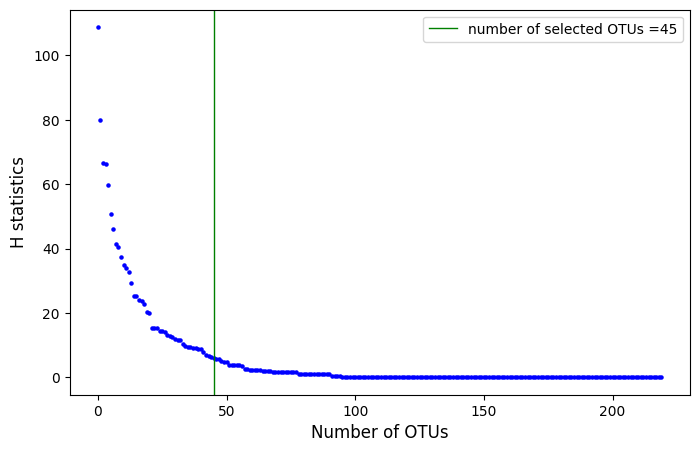

In [10]:
# 2. calculating H score for each OTU
selectedresult=FS.SelectMicro_fun(data,y,p_cutoff = 0.05)

selectedresult.keys()

In [11]:
selectedOTU_index= selectedresult['selected_indices']
X_FS = selectedresult['selected_df']
#selectedASV = X_FS.columns


In [12]:
custom_order = ['nonIBD', 'CD', 'UC']
custom_mapping = {category: i for i, category in enumerate(custom_order)}

In [13]:
target_variable = [custom_mapping[category] for category in y]
target_variable = np.array(target_variable)

In [14]:
dunn_results, summary = FS.calculate_dunn_tests_pair(
    X_FS,
    target_variable,
    p_threshold=0.05
)

In [15]:
# Set pandas to display all rows
pd.set_option('display.max_rows', None)

# Assuming your dataframe is named df
print(summary)

# Optionally, reset back to default if needed
pd.reset_option('display.max_rows')

                                              Feature  Group1  Group2  \
0   c__Clostridia|o__Clostridiales|f__Ruminococcac...       0       1   
1   c__Clostridia|o__Clostridiales|f__Ruminococcac...       1       2   
2   c__Gammaproteobacteria|o__Enterobacteriales|f_...       0       1   
3   c__Gammaproteobacteria|o__Enterobacteriales|f_...       1       2   
4   c__Bacteroidia|o__Bacteroidales|f__Prevotellac...       0       1   
5   c__Bacteroidia|o__Bacteroidales|f__Prevotellac...       0       2   
6   c__Clostridia|o__Clostridiales|f__Ruminococcac...       0       1   
7   c__Clostridia|o__Clostridiales|f__Ruminococcac...       1       2   
8   c__Clostridia|o__Clostridiales|f__Veillonellac...       0       1   
9   c__Clostridia|o__Clostridiales|f__Veillonellac...       1       2   
10  c__Clostridia|o__Clostridiales|f__Ruminococcac...       0       1   
11  c__Clostridia|o__Clostridiales|f__Ruminococcac...       1       2   
12             c__Clostridia|o__Clostridiales|f__|g

In [16]:
subset = summary[summary['Group1'] == 1]['Feature'].unique()
subset

array(['c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__',
       'c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__',
       'c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium',
       'c__Clostridia|o__Clostridiales|f__Veillonellaceae|g__Veillonella',
       'c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus',
       'c__Clostridia|o__Clostridiales|f__|g__',
       'c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Oscillospira',
       'c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__',
       'c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium',
       'c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__',
       'c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Akkermansia',
       'c__Clostridia|o__Clostridiales|f__Veillonellaceae|g__Megasphaera',
       'c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Morganella',
       'c__Clostridia|o__Clostridia

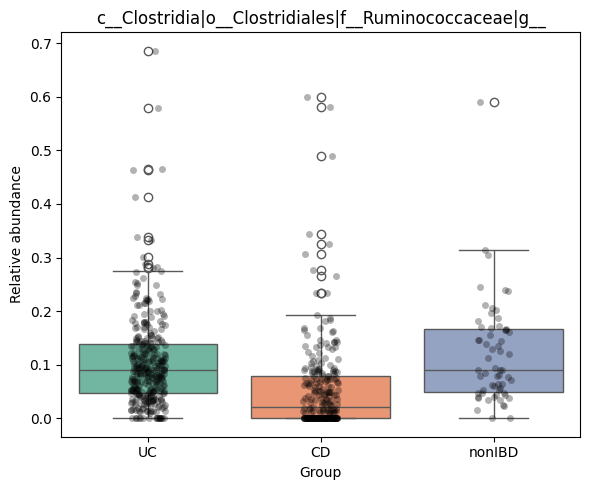

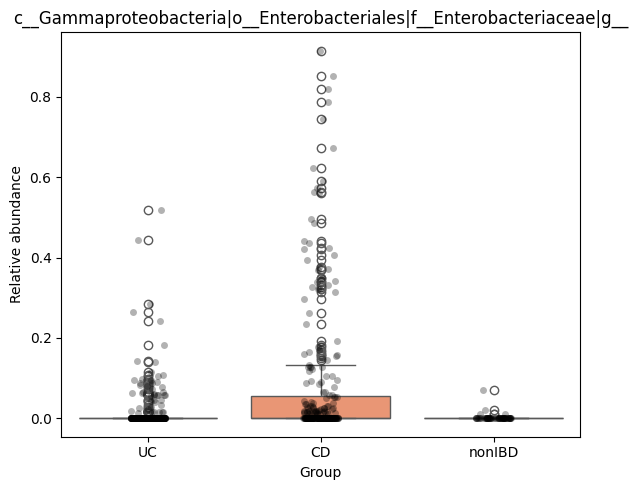

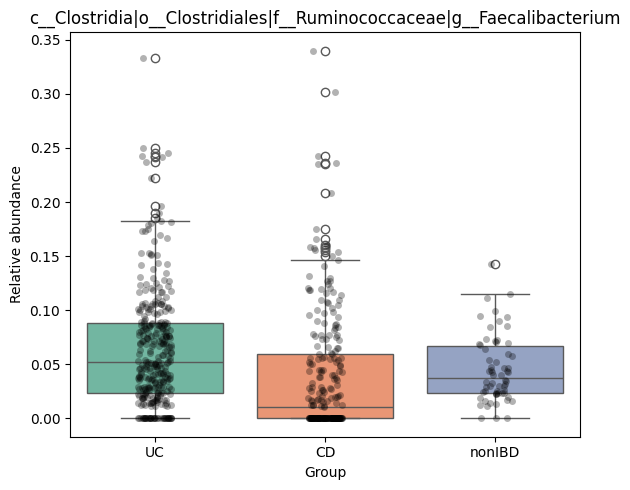

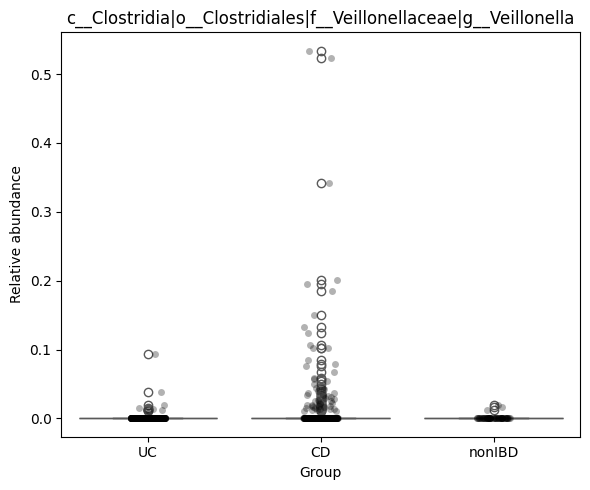

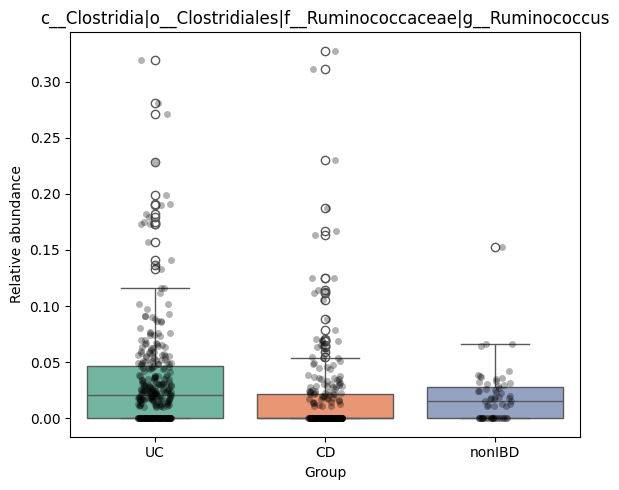

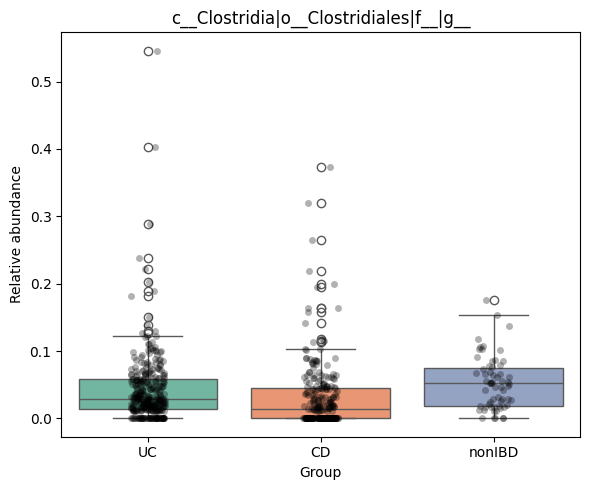

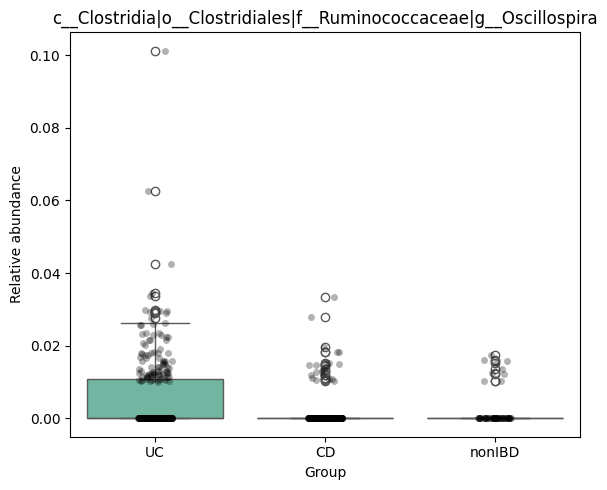

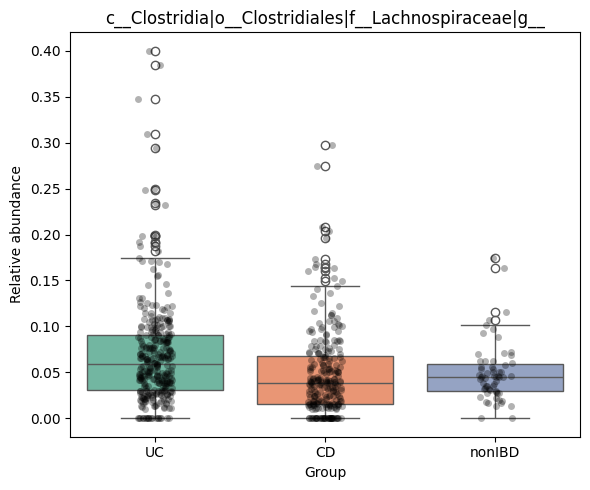

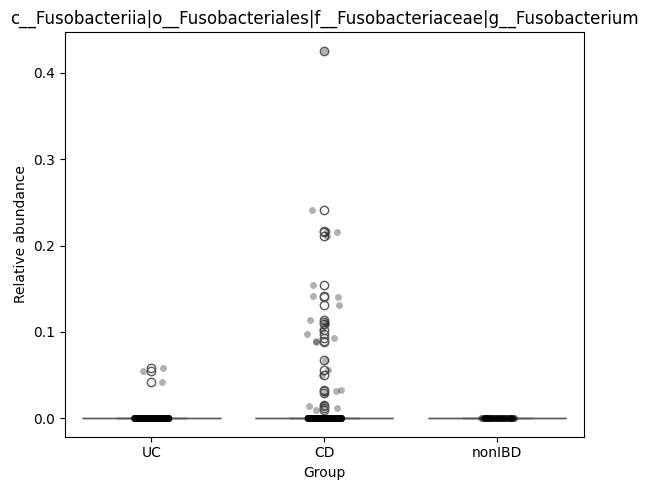

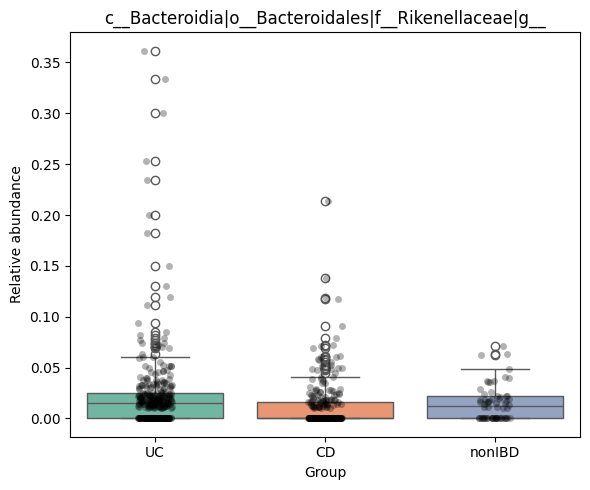

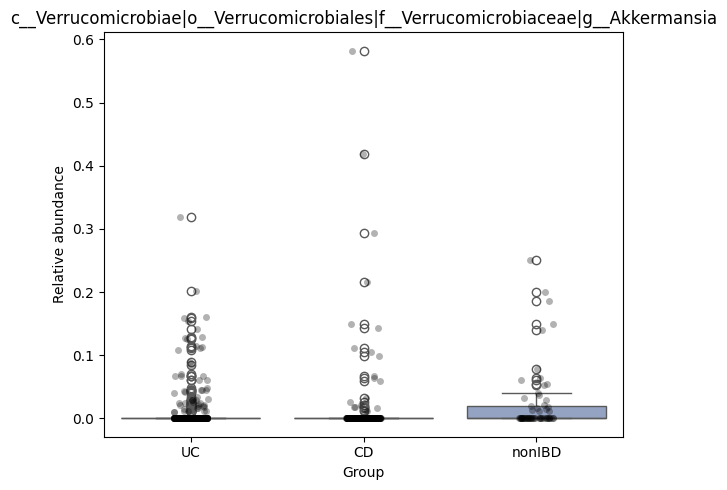

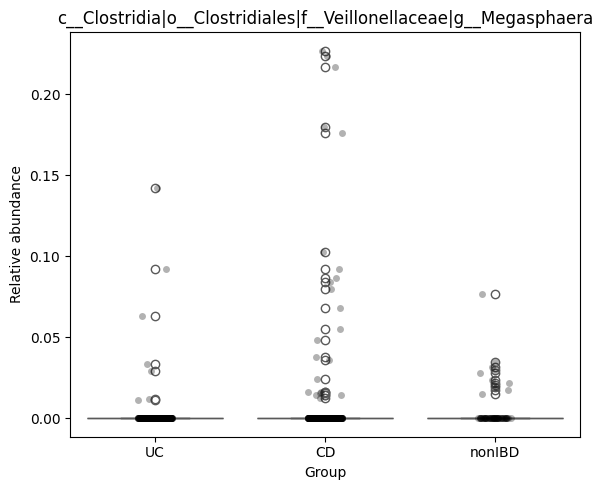

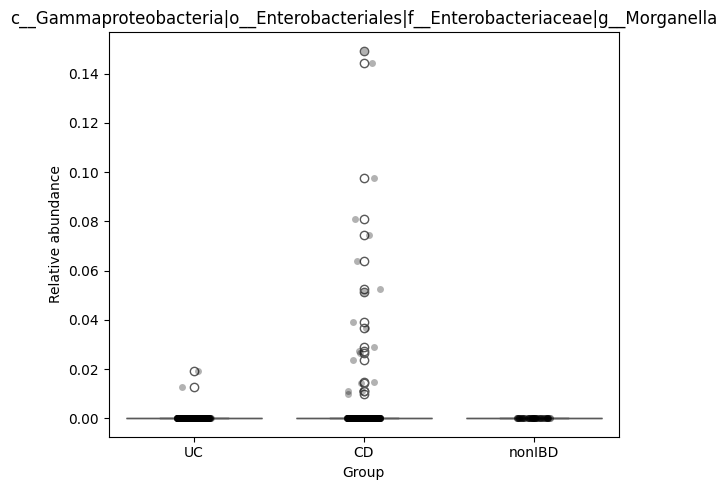

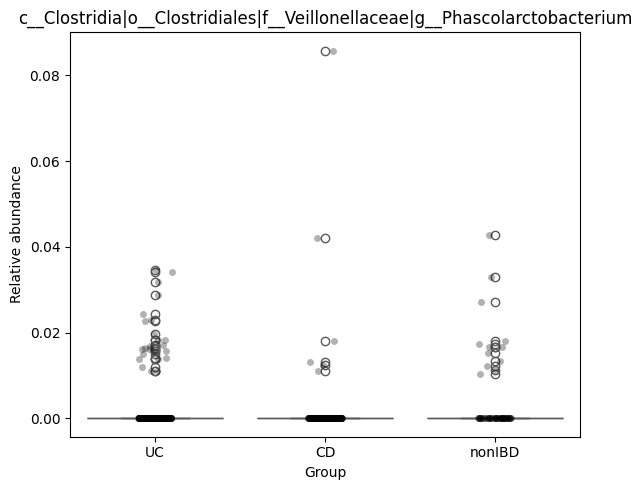

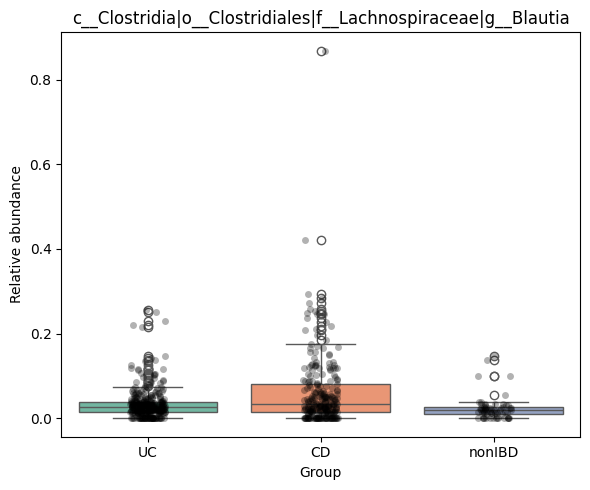

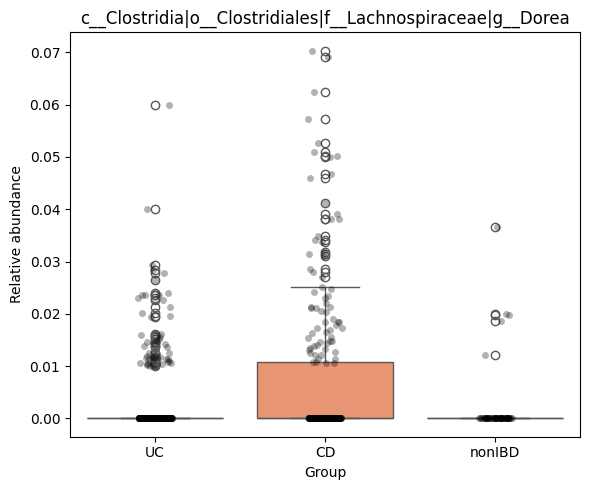

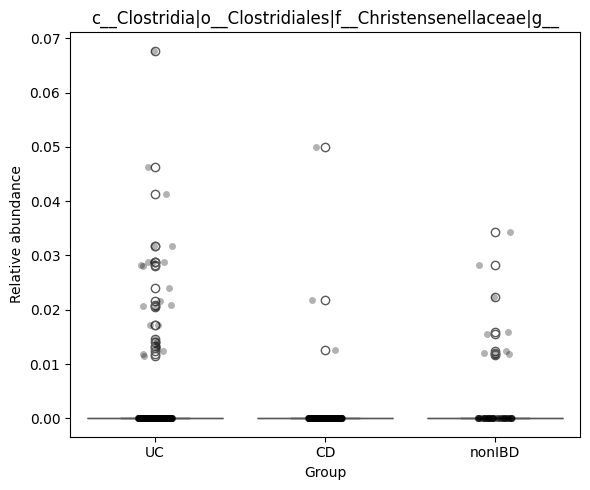

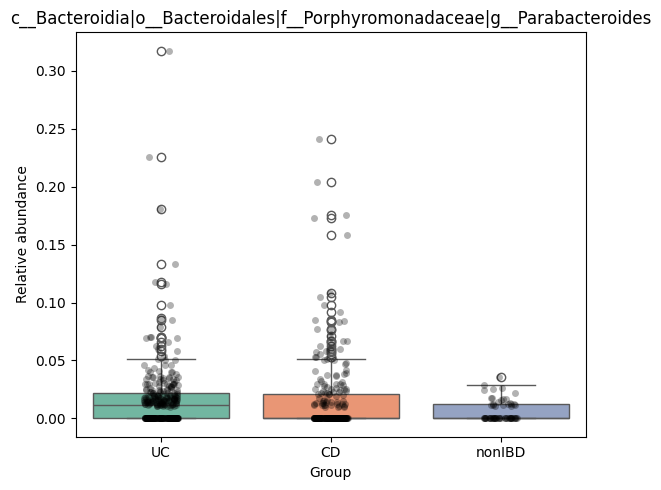

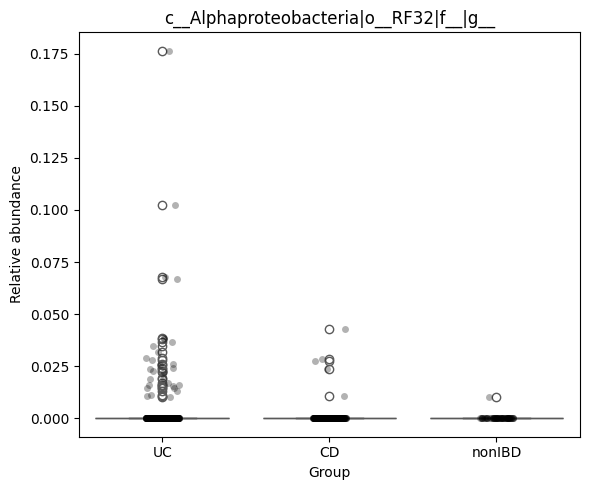

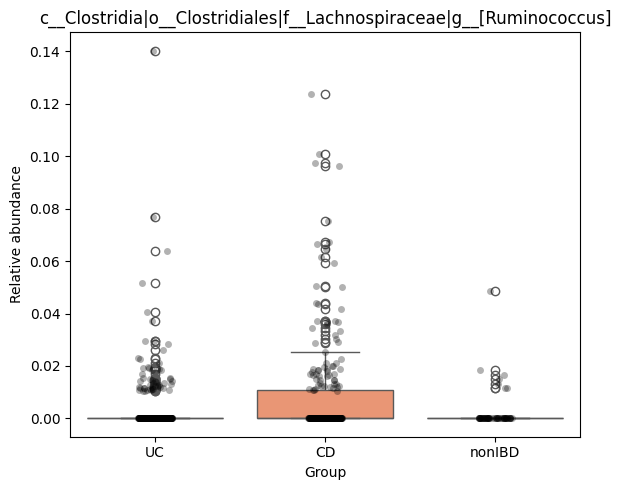

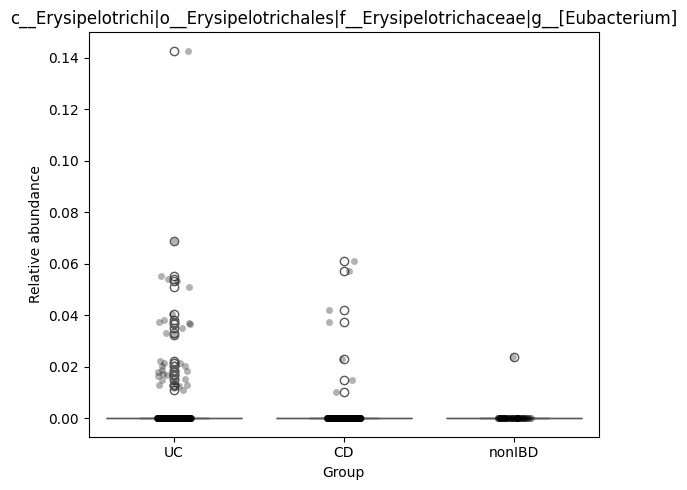

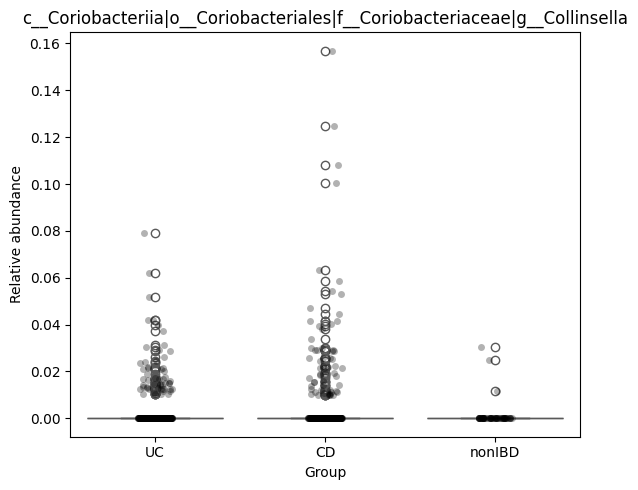

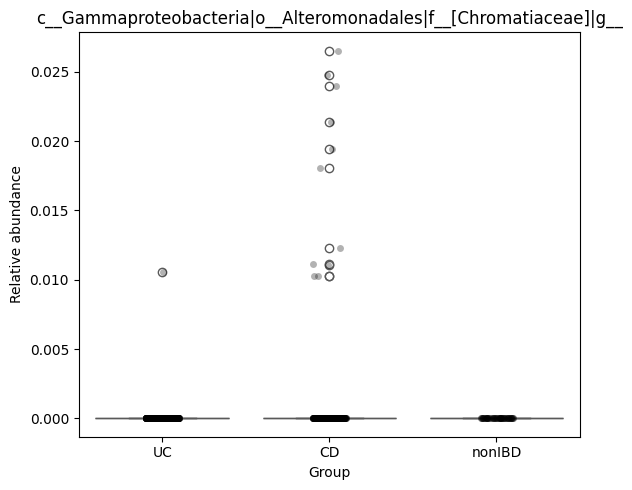

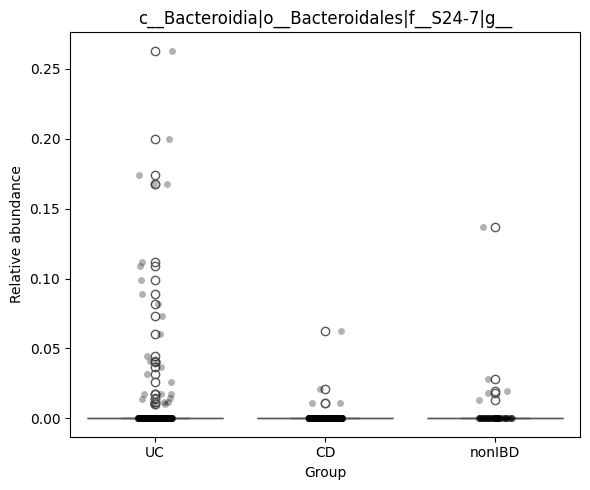

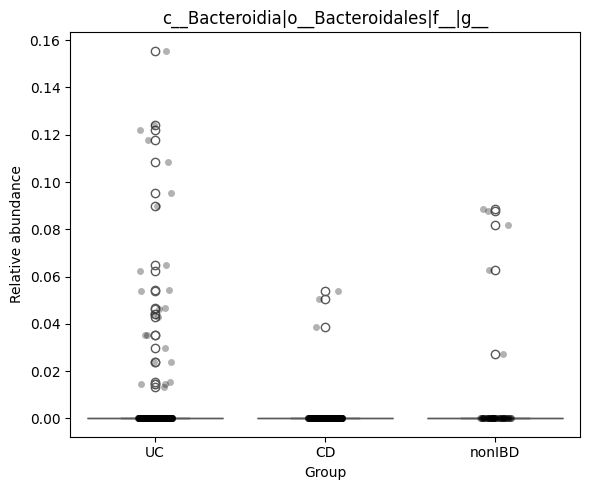

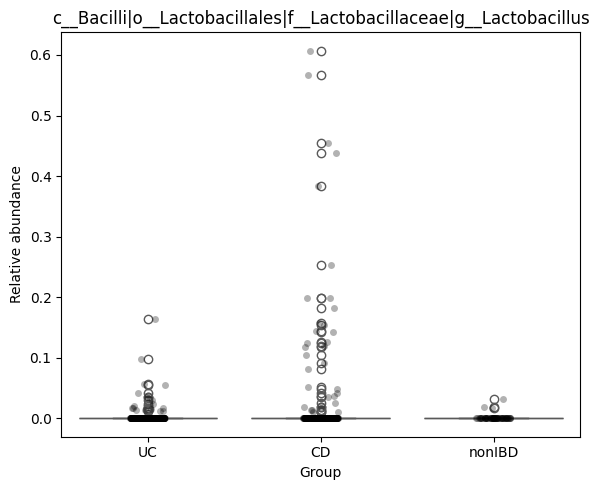

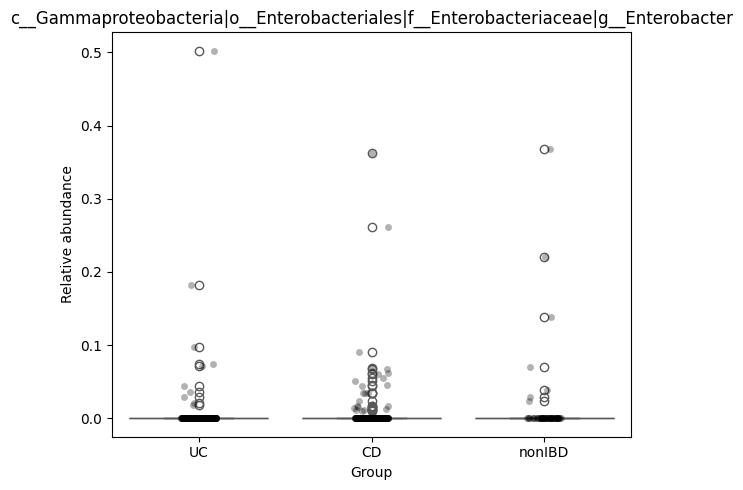

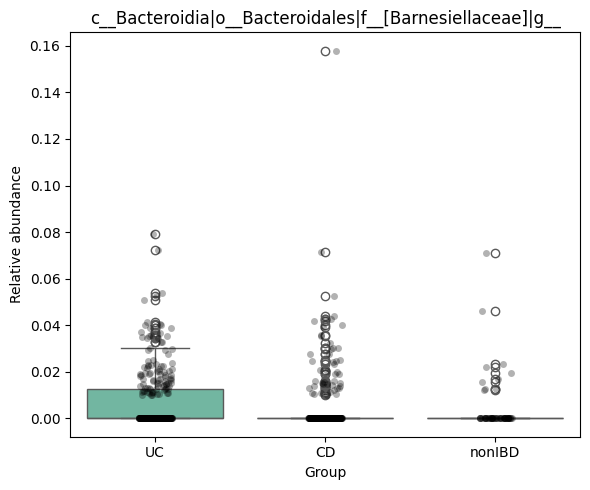

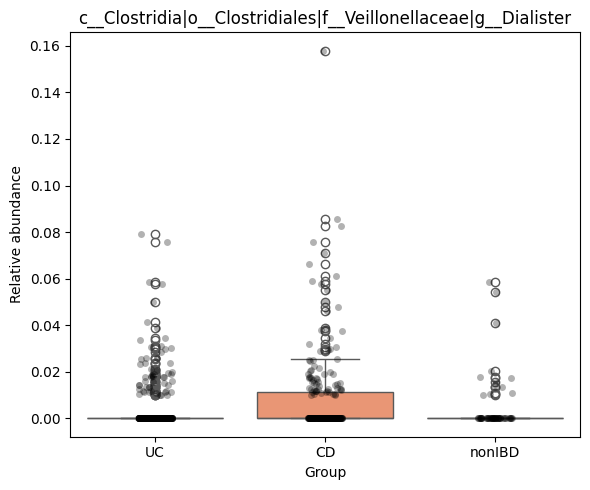

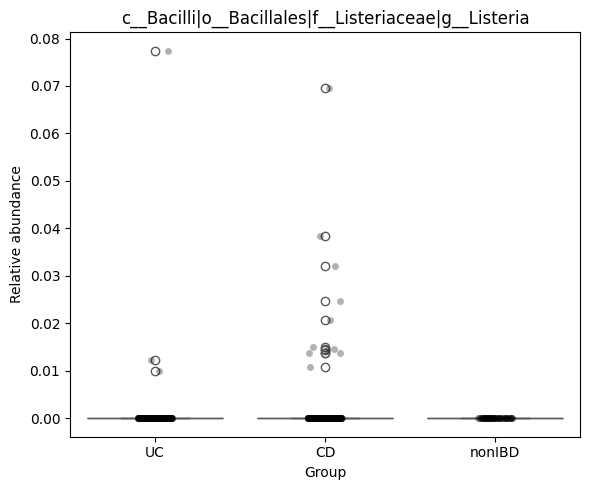

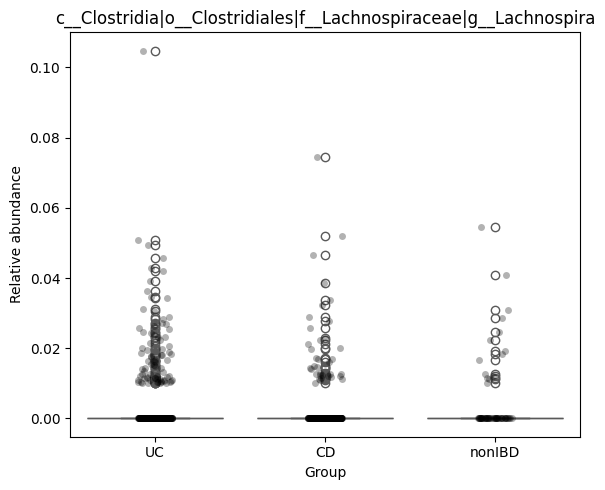

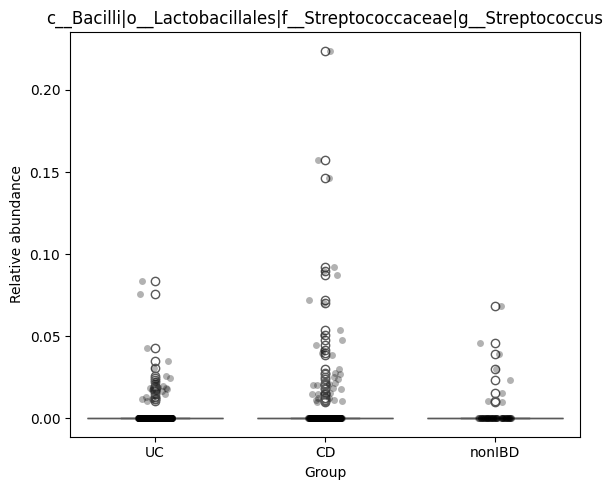

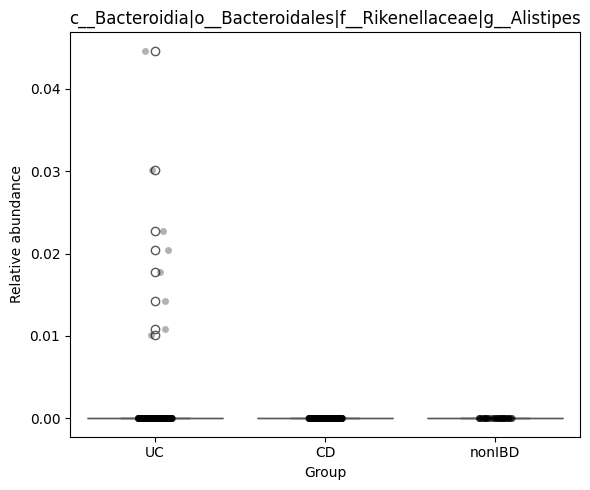

In [17]:



# select some of the features
for feature in subset:
    df_dunntest_x = X_FS[[feature]].copy()
    df_dunntest_x['Group'] = y.values
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df_dunntest_x, x='Group', y=feature, hue='Group', palette='Set2', legend=False)
    sns.stripplot(data=df_dunntest_x, x='Group', y=feature, color='black', alpha=0.3, jitter=True)
    plt.ylabel("Relative abundance")  # Replace with your desired title
    plt.title(f"{feature}")
    plt.tight_layout()
    plt.show()



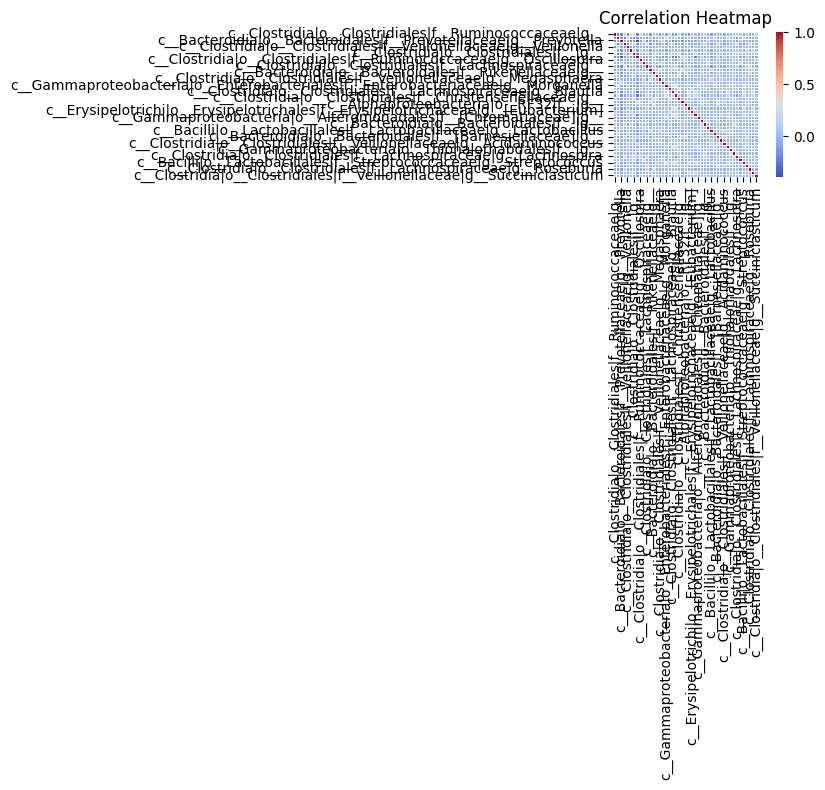

In [18]:
# Compute correlation matrix
corr = X_FS.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [19]:
X_lasso_ft0,selectedOTU_index_Lasso  = RunML.LassoFS_CV(np.array(data),target_variable)
X_lasso_ft = pd.DataFrame(X_lasso_ft0, columns=cols_name[selectedOTU_index_Lasso])

X_FS_lasso_ft0,xlabel_FS_lasso_ft0  = RunML.LassoFS_CV(np.array(X_FS),target_variable)
selectedOTU_index_FS_lasso = selectedOTU_index[xlabel_FS_lasso_ft0]
X_FS_lasso_ft = pd.DataFrame(X_FS_lasso_ft0, columns=cols_name[selectedOTU_index_FS_lasso])

data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lassofinetune":X_FS_lasso_ft
              }

Best alpha: 0.05
Best alpha: 0.05


In [20]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))


The shape of the original dataset is  (637, 220)
The shape of the SelectMicro dataset is  (637, 45)
The shape of the Lasso_finetune selected dataset is  (637, 15)
The shape of the FS_Lasso_finetune selected dataset is  (637, 14)


/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


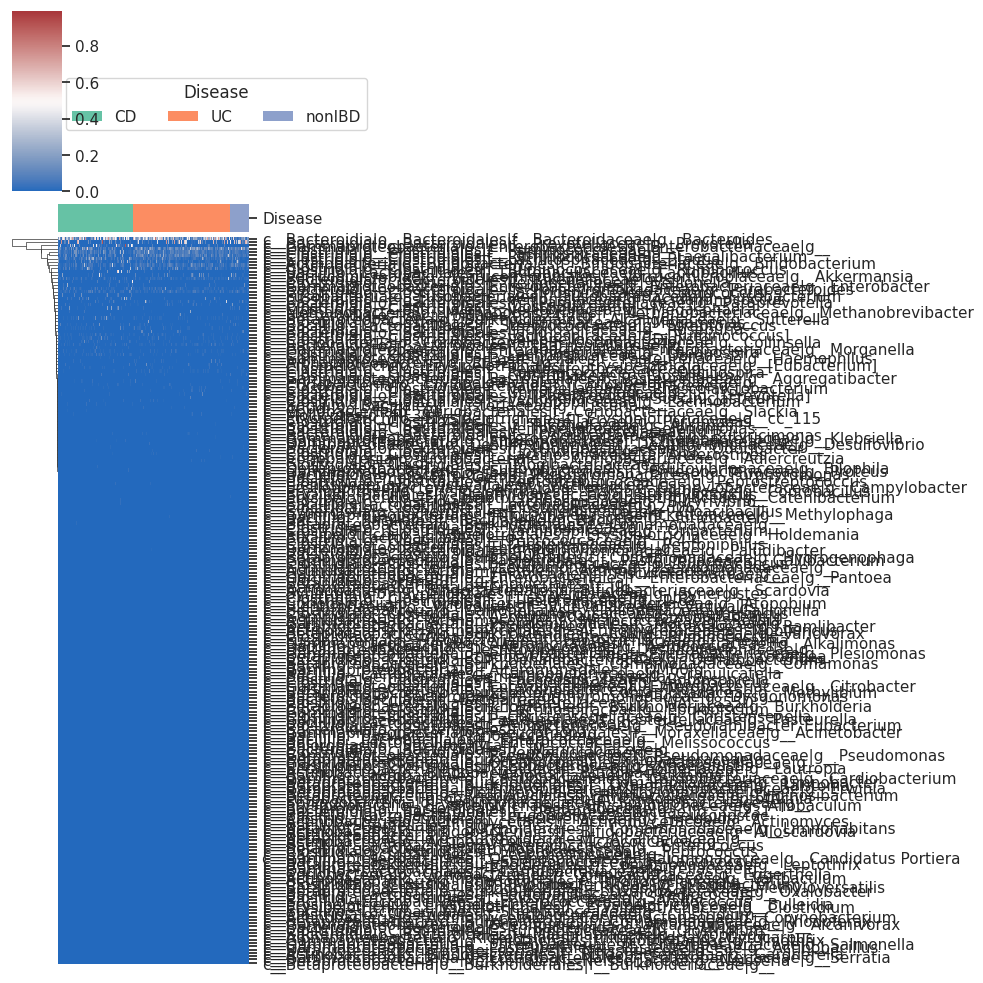

/lustre/isaac24/scratch/mhe8/myenv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


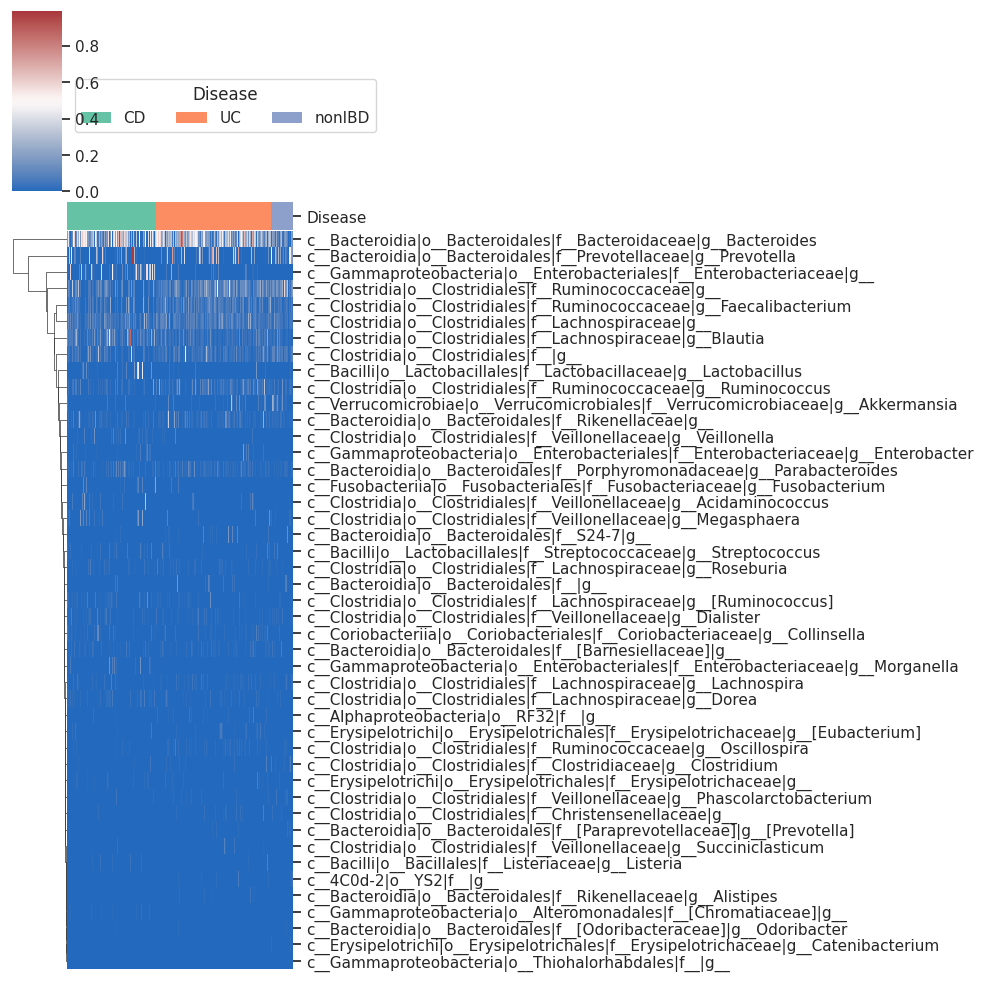

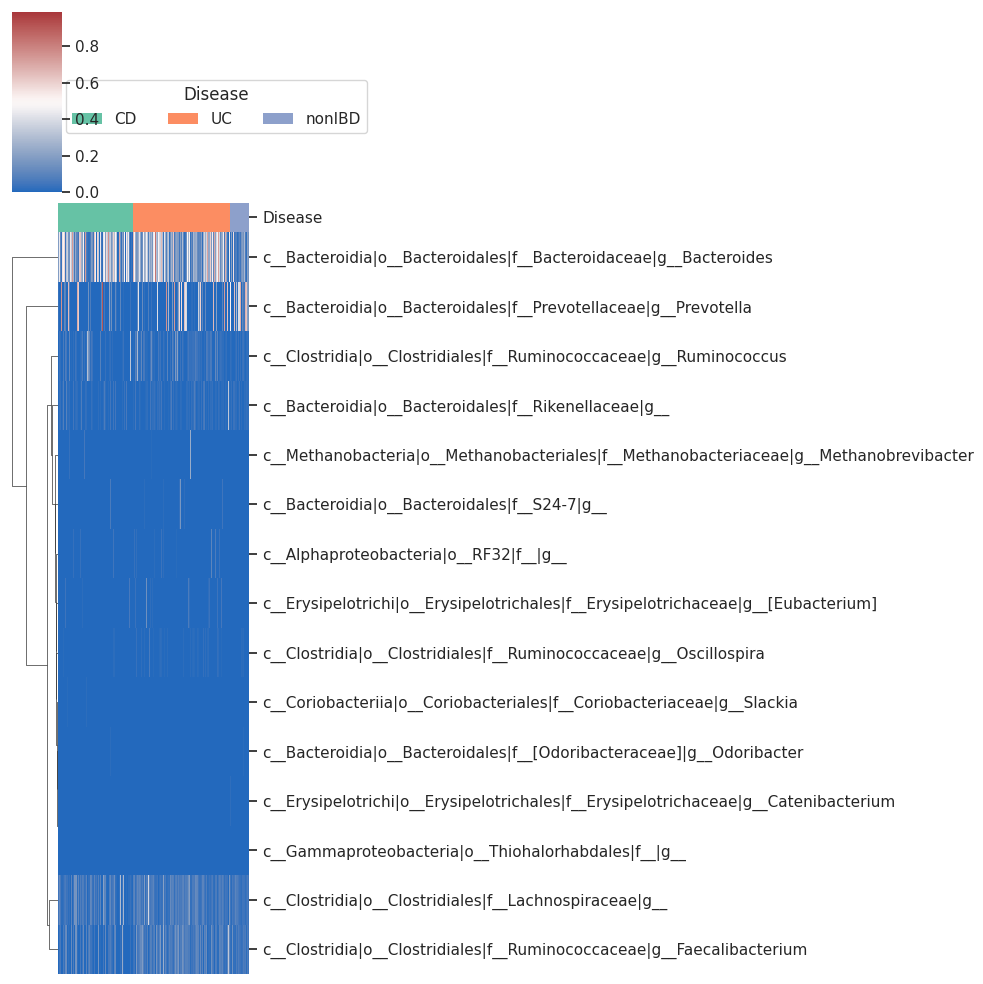

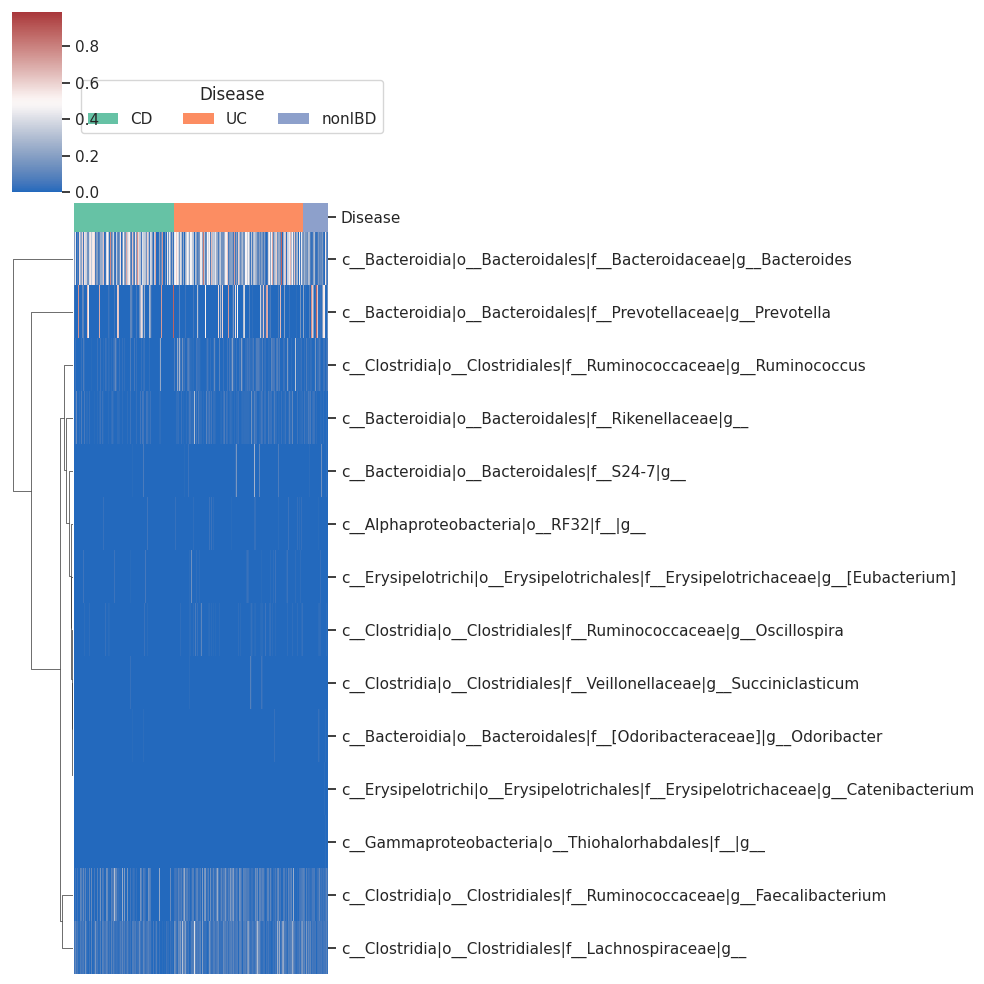

In [21]:
group = pd.DataFrame({'Disease': y})
group.index = meta_2.index
group = group.loc[qitta_2.index]

for datatype, subset in data_subset.items():
    subset.index = qitta_2.index
    metric.plot_heatmap(subset,group)
    
    
    

### plot for a feature



In [22]:
plt.figure(figsize=(6, 5))
sns.heatmap(dunn_results["g__Akkermansia"].astype(float), annot=True, cmap='coolwarm', fmt=".4f", cbar_kws={'label': 'p-value'})
plt.title(f"Dunn's Test P-values: g__Akkermansia")
plt.tight_layout()
#plt.savefig(os.path.join(output_diry, f"{column}_dunn_heatmap.png"))
plt.show()

KeyError: 'g__Akkermansia'

<Figure size 600x500 with 0 Axes>

In [ ]:
df_dunntest_x = X_FS[["g__Akkermansia"]].copy()
df_dunntest_x['Group'] = y.values
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_dunntest_x, x='Group', y='g__Akkermansia', hue='Group', palette='Set2', legend=False)
sns.stripplot(data=df_dunntest_x, x='Group', y='g__Akkermansia', color='black', alpha=0.3, jitter=True)
plt.title(f"Boxplot  by Group")
plt.tight_layout()
plt.show()

